# Concevez une application au service de la santé publique

L'agence Santé publique France a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Vous souhaitez y participer et proposer une idée d’application.

# Sommaire

- **Partie 1:** <a href="#C1">Importation des données</a>
- **Partie 2:** <a href="#C2">Nettoyage des données</a>
    - <a href="#C3">Valeurs manquantes</a>
    - <a href="#C4">Doublons</a>
    - <a href="#C5">Valeurs aberrantes</a>
    - <a href="#C6">Création d'une nouvelle variable</a>
- **Partie 3:** <a href="#C7">Exportation du jeu de données néttoyé</a>

# <a name="C1">Partie 1: Importation des données</a>

Les données utilisées sont considérées être dans le même dossier que ce notebook. Importons dans un premier temps les librairies qui vont nous servir pour l'importation et le nettoyage des données. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

Nous pouvons à présent charger le jeu de données dans un dataframe que nous nomerons `data`, en faisant attention au typage du fichier précisé dans la [notice d'utilisation](https://world.openfoodfacts.org/data/data-fields.txt).

In [2]:
data_original = pd.read_csv('fr.openfoodfacts.org.products.csv',sep='\t',encoding='utf-8')
data = data_original.copy()

C:\Users\vbour\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.shape

(320772, 162)

La commande ci-dessus nous indique que nous avons 320 772 produits alimentaires renseignés sur 162 variables.

In [5]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

On préfererait que la variable `code` soit de type numérique.

In [6]:
data['code'] = pd.to_numeric(data['code'], errors='coerce')
data.dtypes

code                       float64
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

# <a name="C2">Partie 2: Nettoyage des données</a>
L'idée de lapplication est de pouvoir scanner ou rentrer le code d'un produit alimentaire et d'obtenir en sortie les régimes alimentaires pouvant consommer ce produit (végan, végétarien, sans régime), le nutriscore, l'origine, ainsi qu'une note d'impact environnemental. Les variables qui semblent à première vue intéressantes sont les suivantes: `code`, `product_name`, `categories_fr`, `origins`, `manufacturing_places`, `labels`, `nutrition_grade_fr`, `carbon-footprint_100g`, `pnns_groups_1` et `pnns_groups_2`.
## <a name="C3">2.1 Valeurs manquantes</a>
Pour commencer, on va s'intéresser aux valeurs manquantes pour chaque variable.

In [7]:
def quantite_valeurs_manquantes(data):
    """fonction permettant d'obtenir le nombre et le pourcentage de valeurs manquantes pour chaque variable d'un dataframe, 
    dans l'ordre décroissant"""
    
    valeurs = data.isnull().sum()
    pourcentage = 100 * data.isnull().sum() / len(data)
    table = pd.concat([valeurs, pourcentage.round(2)], axis=1)
    table.columns = ['Nombre de valeurs manquantes', '% de valeurs manquantes']
    
    return table[table['Nombre de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending = False).style.background_gradient('OrRd')

In [8]:
quantite_valeurs_manquantes(data)

,Nombre de valeurs manquantes,% de valeurs manquantes
water-hardness_100g,320772,100.000000
caproic-acid_100g,320772,100.000000
elaidic-acid_100g,320772,100.000000
nucleotides_100g,320763,100.000000
ingredients_that_may_be_from_palm_oil,320772,100.000000
nutrition_grade_uk,320772,100.000000
serum-proteins_100g,320756,100.000000
maltodextrins_100g,320761,100.000000
maltose_100g,320768,100.000000
nervonic-acid_100g,320772,100.000000


On voit que de nombreuses colonnes sont complètement vides. On peut se demander si ces varibales sont vides car les données n'existent pas ou car elles n'ont pas été renseignées. Il semblerait que ce soient des données nutritionnelles qui n'apparaissent que rarement sur les emballages. Il semble donc difficile d'estimer ces valeurs. Et comme elles ne représentent pas un intérêt particulier pour notre application, supprimons-les. 

In [9]:
data.dropna(axis = 1, how = 'all', inplace = True)
data.shape

(320772, 146)

Certaines données manquantes peuvent être remplacées sans difficulté, par exemple la variable `code`. En effet, le code ne sert qu'à identifier de manière unique un produit et on peut donc en attribuer un de manière arbitraire. On peut par exemple incrémenter à partir du code le plus grand.

In [10]:
#On commence par récupérer la liste d'index des codes non renseignés
listeIndex = data[data['code'].isnull()].index

#On récupère le plus grand code
masque = data['code'].isnull()
df = data[~masque]
tab = list(df['code'].values)
maxCode = max(tab)

#On affecte une valeur aux codes manquants
j = 1
for i in listeIndex:
    data.iloc[i,0] = maxCode + j
    j+=1
    
#On vérifie qu'il n'y a plus de valeur manquante    
data['code'].isnull().sum()

0

Une autre possibilité pour estimer les valeurs manquantes est d'utiliser les autres données disponibles. Par exemple, pour estimer les valeurs manquantes de la variable `nutrition_grade_fr` on peut utiliser la formule de calcul du nutriscore avec les variables `energy_100g`, `saturated-fat_100g`, `sugars_100g`, `fiber_100g`, `proteins_100g`, `sodium_100g` et `fruits-vegetables-nuts_100g`, variables pour lesquelles on remplace les valeurs manquantes par la valeur médiane.

In [11]:
variablesNutriscore = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                       'fruits-vegetables-nuts_100g']

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(data[variablesNutriscore])

data[variablesNutriscore] = imputer.transform(data[variablesNutriscore])

In [12]:
def calculNutriscore(liste):
    """fonction qui calcule le nutriscore d'un produit avec pour argument la liste du nutriscore et des quantités de nutriments
    pour 100g, c'est à dire une liste de la forme: [nutriscore, énergie/100g, graisses saturées/100g, sucre/100g, fibres/100g, 
    protéines/100g, sodium/100g, teneur en fruits, légumes, noix/100g]."""
    
    N,P =0,0 #scores des nutiments à limiter,encourager
    
    #quantité d'énergie
    energie = liste[1]
    if 335 <= energie < 670:
        N+=1
    elif energie < 1005:
        N+=2
    elif energie < 1340:
        N+=3
    elif energie < 1675:
        N+=4
    elif energie < 2010:
        N+=5
    elif energie < 2345:
        N+=6
    elif energie < 2680:
        N+=7
    elif energie < 3015:
        N+=8
    elif energie < 3350:
        N+=9
    else:
        N+=10
        
    #quantité de graisses saturées
    graisse = liste[2]
    if 1 <= graisse < 2:
        N+=1
    elif graisse < 3:
        N+=2
    elif graisse < 4:
        N+=3
    elif graisse < 5:
        N+=4
    elif graisse < 6:
        N+=5
    elif graisse < 7:
        N+=6
    elif graisse < 8:
        N+=7
    elif graisse < 9:
        N+=8
    elif graisse < 10:
        N+=9
    else:
        N+=10
        
    #quantité de sucre
    sucre = liste[3]
    if 0 < sucre <= 1.5:
        N+=1
    elif sucre <= 3:
        N+=2
    elif sucre <= 4.5:
        N+=3
    elif sucre <= 6:
        N+=4
    elif sucre <= 7.5:
        N+=5
    elif sucre <= 9:
        N+=6
    elif sucre <= 10.5:
        N+=7
    elif sucre <= 12:
        N+=8
    elif sucre <= 13.5:
        N+=9
    else:
        N+=10
    
    #quantité de fibres
    fibre = liste[4]
    scoreFibre = 0
    if 0.7 < fibre <= 1.4:
        P+=1
        scoreFibre = 1
    elif fibre <= 2.1:
        P+=2
        sccoreFibre = 2
    elif fibre <= 2.8:
        P+=3
        scoreFibre = 3
    elif fibre <= 3.5:
        P+=4
        scoreFibre = 4
    else:
        P+=5
        scoreFibre = 5
        
    #quantité de protéines
    proteine = liste[5]
    if 1.6 < proteine <= 3.2:
        P+=1
    elif proteine <= 4.8:
        P+=2
    elif proteine <= 6.4:
        P+=3
    elif proteine <= 8:
        P+=4 
    else:
        P+=5
        
    #quantité de sodium 
    sodium = liste[6]
    if 90 < sodium <= 180:
        N+=1
    elif sodium <= 270:
        N+=2
    elif sodium <= 360:
        N+=3
    elif sodium <= 450:
        N+=4
    elif sodium <= 540:
        N+=5
    elif sodium <= 630:
        N+=6
    elif sodium <= 720:
        N+=7
    elif sodium <= 810:
        N+=8
    elif sodium <= 900:
        N+=9
    else:
        N+=10
        
    #quantité de fruits, légumes, noix
    fruit = liste[7]
    scoreFruit = 0
    if 40 < fruit <= 60:
        P+=1
        scoreFruit = 1
    elif fruit <= 80:
        P+=2
        scoreFruit = 2
    else:
        P+=5
        scoreFruit = 5
        
    #calcul du nutriscore
    nutriscore = 0
    if N >= 11:
        if scoreFruit == 5:
            nutriscore = N - P
        else:
            nutriscore = N - scoreFibre - scoreFruit
    else:
        nutrisscore = N - P
        
    #calcul de la lettre équivalente
    if nutriscore < 0:
        liste[0] = 'a'
    elif nutriscore <= 2:
        liste[0] = 'b'
    elif nutriscore <= 10:
        liste[0] = 'c'
    elif nutriscore <= 18:
        liste[0] = 'd'
    else:
        liste[0] = 'e'
    return liste

On peut désormais calculer les nutriscores manquants.

In [13]:
masque = data['nutrition_grade_fr'].isnull()
listeVariables = ['nutrition_grade_fr', 'energy_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 
                  'sodium_100g', 'fruits-vegetables-nuts_100g']

data[masque].loc[:,listeVariables].head()

,nutrition_grade_fr,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
0,NaN,1100.0,1.79,5.71,1.5,4.76,0.229,23.0
4,NaN,1552.0,1.79,5.71,5.7,8.57,0.229,23.0
5,NaN,1933.0,1.92,11.54,7.7,13.46,0.229,23.0
6,NaN,1490.0,1.79,5.71,1.5,8.89,0.229,23.0
8,NaN,2406.0,22.50,42.50,7.5,5.00,0.229,23.0


In [14]:
data.loc[:,listeVariables] = (data.loc[:,listeVariables]).apply(calculNutriscore, axis=1)
data['nutrition_grade_fr'].isnull().sum()

0

Pour remplir les valeurs manquantes de la variable `product_name`, on va attribuer le nom de produit qui est le plus présent pour le nutriscore correspondant. 

In [15]:
listeNutriscore = ['a', 'b', 'c', 'd', 'e']

for score in listeNutriscore:
    #on récupère le produit le plus fréquent pour le nutriscore donné
    plusFrequentProduit = (data.loc[data['nutrition_grade_fr']==score]).loc[:,'product_name'].value_counts().index[0]
    data.loc[((data['product_name'].isnull()) & (data['nutrition_grade_fr']==score)), 'product_name'] = plusFrequentProduit

In [16]:
data['product_name'].isnull().sum()

0

On va traiter de la même façon les valeurs manquantes des variables `categories_fr`, `pnns_groups_1` et `pnns_groups_2`.

In [17]:
listeVariables = ['categories_fr', 'pnns_groups_1', 'pnns_groups_2']

for variable in listeVariables:
    for score in listeNutriscore:
        plusFrequentProduit = (data.loc[data['nutrition_grade_fr']==score]).loc[:,variable].value_counts().index[0]
        data.loc[((data[variable].isnull()) & (data['nutrition_grade_fr']==score)), variable] = plusFrequentProduit

In [18]:
data[listeVariables].isnull().sum()

categories_fr    0
pnns_groups_1    0
pnns_groups_2    0
dtype: int64

In [19]:
data[['origins', 'manufacturing_places', 'labels', 'carbon-footprint_100g']].isnull().mean()

origins                  0.930823
manufacturing_places     0.886209
labels                   0.854853
carbon-footprint_100g    0.999165
dtype: float64

Pour la variable `carbon-footprint_100g`, trop peu de données sont connues pour pouvoir évaluer les valeurs manquantes. On va donc oublier cette variable pour notre idée d'application. Pour les autres variables, on peut choisir de les conserver et d'indiquer par exemple l'origine d'un produit seulement lorsqu'elle est connue. On remplace les valeurs manquantes par une mention '**Inconnu**'.

In [20]:
listeVariables = ['origins', 'manufacturing_places', 'labels']

for variable in listeVariables:
    data[variable].fillna(value='Inconnu', inplace=True)


In [21]:
data[listeVariables].isnull().sum()

origins                 0
manufacturing_places    0
labels                  0
dtype: int64

## <a name="C4">2.2 Doublons</a>
On veu s'assurer qu'aucune ligne n'est en doublon.

In [22]:
data.loc[data.duplicated()]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


Il n'y a aucune ligne répétée en double dans le jeu de donnée. Toutefois, cela n'exclut pas complètement la possibilité de doublons. Pour cela, on va vérifier qu'il n'y a pas de doublon dans la variable `code`, car c'est elle qui identifie de manière unique chaque produit. 

In [23]:
data.loc[data['code'].duplicated(keep=False),:]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
6,1.611700e+04,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
46,2.460000e+04,http://world-fr.openfoodfacts.org/produit/0000...,date-limite-app,1434530704,2015-06-17T08:45:04Z,1434535914,2015-06-17T10:11:54Z,Filet de bœuf,NaN,2.46 kg,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
62,3.123300e+04,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055717,2017-03-09T10:35:17Z,1489055717,2017-03-09T10:35:17Z,35% Fruit And Fiber Muesli,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
155,5.800100e+04,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055734,2017-03-09T10:35:34Z,1489055734,2017-03-09T10:35:34Z,Organic Salted Pistachios,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,15.0,15.0
178,1.471762e+06,http://world-fr.openfoodfacts.org/produit/0000...,canieatthis-app,1470247218,2016-08-03T18:00:18Z,1470247218,2016-08-03T18:00:18Z,still Scottish water,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320744,9.800120e+09,http://world-fr.openfoodfacts.org/produit/9800...,openfoodfacts-contributors,1491776869,2017-04-09T22:27:49Z,1491776873,2017-04-09T22:27:53Z,Ferrero Rocher,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
320745,9.800801e+09,http://world-fr.openfoodfacts.org/produit/9800...,tacite-mass-editor,1490554697,2017-03-26T18:58:17Z,1490554697,2017-03-26T18:58:17Z,Pinto Beans,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
320746,9.800895e+09,http://world-fr.openfoodfacts.org/produit/9800...,tacite-mass-editor,1490554698,2017-03-26T18:58:18Z,1490554698,2017-03-26T18:58:18Z,Pinto Beans,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
320747,9.800895e+09,http://world-fr.openfoodfacts.org/produit/9800...,tacite-mass-editor,1490554697,2017-03-26T18:58:17Z,1490554697,2017-03-26T18:58:17Z,Pinto Beans,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN


In [24]:
data[data['code'] == 1.611700e+04]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
6,16117.0,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
481,16117.0,http://world-fr.openfoodfacts.org/produit/0001...,usda-ndb-import,1489065258,2017-03-09T13:14:18Z,1489065258,2017-03-09T13:14:18Z,Colossal Olives With Jalapeno Peppers,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN


In [25]:
data.loc[data[['code', 'product_name']].duplicated(keep=False),:]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
422,9.800800e+09,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489061721,2017-03-09T12:15:21Z,1489061721,2017-03-09T12:15:21Z,Hazelnut Spread + Breadsticks,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,21.0,21.0
438,1.111068e+10,http://world-fr.openfoodfacts.org/produit/0001...,usda-ndb-import,1489061722,2017-03-09T12:15:22Z,1489061722,2017-03-09T12:15:22Z,Strawberry Preserves,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
440,1.111088e+10,http://world-fr.openfoodfacts.org/produit/0001...,usda-ndb-import,1489142846,2017-03-10T10:47:26Z,1489142846,2017-03-10T10:47:26Z,Vindaloo Sauce,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,4.0,4.0
512,2.392320e+10,http://world-fr.openfoodfacts.org/produit/0002...,usda-ndb-import,1489061516,2017-03-09T12:11:56Z,1489061516,2017-03-09T12:11:56Z,Organic Sunny Days Snack Bars,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,13.0,13.0
516,2.446306e+10,http://world-fr.openfoodfacts.org/produit/0002...,usda-ndb-import,1489061794,2017-03-09T12:16:34Z,1489061795,2017-03-09T12:16:35Z,Sriracha Hot Chili Sauce,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285971,7.592530e+10,http://world-fr.openfoodfacts.org/produit/7592...,usda-ndb-import,1489056423,2017-03-09T10:47:03Z,1489056423,2017-03-09T10:47:03Z,Baby Swiss Cheese,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,19.0,19.0
285981,7.592530e+10,http://world-fr.openfoodfacts.org/produit/7592...,usda-ndb-import,1489056422,2017-03-09T10:47:02Z,1489056422,2017-03-09T10:47:02Z,Cheddar Jack Cheese,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,21.0,21.0
286001,7.592531e+10,http://world-fr.openfoodfacts.org/produit/7592...,usda-ndb-import,1489056427,2017-03-09T10:47:07Z,1489056427,2017-03-09T10:47:07Z,Pizza Cheese,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,20.0,20.0
320325,9.396611e+10,http://world-fr.openfoodfacts.org/produit/9396...,usda-ndb-import,1489062676,2017-03-09T12:31:16Z,1489062676,2017-03-09T12:31:16Z,Raw Mild Cheddar Cheese,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,20.0,20.0


In [26]:
data[data['code'] == data.iloc[422,0]]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
422,9.800800e+09,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489061721,2017-03-09T12:15:21Z,1489061721,2017-03-09T12:15:21Z,Hazelnut Spread + Breadsticks,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,21.0,21.0
1337,9.800800e+09,http://world-fr.openfoodfacts.org/produit/0009...,openfoodfacts-contributors,1457659842,2016-03-11T01:30:42Z,1489068296,2017-03-09T14:04:56Z,Hazelnut Spread + Breadsticks,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,21.0,21.0


On remarque que certains produits ont été ajoutés avec le même code. Il semble que parmis ceux-ci il y ait deux cas possibles:
- Le même code mais des produits différents si on se fie à la variable `product_name`. Dans ce cas on garde chaque entrée mais on change le code.
- Le même code ET le même nom. Dans ce cas il s'agit sûrement de doublons et on peut ne conserver qu'une seule entrée.


In [27]:
#On supprime les doublons en gardant la première occurence
data.drop_duplicates(subset = ['code', 'product_name'], keep = 'first', inplace = True)

data.loc[data[['code', 'product_name']].duplicated(keep=False),:]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


Pour modifer les codes en double on va conserver le code de chaque première occurence puis déclarer un nouveau code comme fait précédemment pour les doublons.

In [28]:
#On réajuste d'abord les index de notre data frame
data.reset_index(inplace=True)

#Récupération du tableau des doublons et de sa liste d'index
dataDoublons = data.loc[data['code'].duplicated(keep=False)]
listeIndexDoublons = dataDoublons['code'].index

#Récupération des index des premières occurences
listeIndex1occurence = (dataDoublons.drop_duplicates(subset=['code'], keep='first')).index

#Récupération du plus petit code (le plus grand code étant un entier trop grand)
minCode = min(list(data['code']))

#Déclaration des nouveaux codes
j=1
for i in list(set.difference(set(listeIndexDoublons),set(listeIndex1occurence))):
    data.iloc[i,0] = minCode - j
    j+=1

## <a name="C5">2.3 Valeurs aberrantes</a>
Intéressons-nous aux potentielles valeurs aberrantes pour les variables `saturated-fat_100g`, `sugars_100g`, `fiber_100g`, `proteins_100g`, `sodium_100g` et `fruits-vegetables-nuts_100g`. Les valeurs associées représentent la quantité, en grammes, du nutriment considéré contenu dans 100g de produit. On sait ainsi que toute valeur en dehors de l'intervalle {0,100} est une valeur aberrante et on peut faire le choix de la remplacer par la valeur moyenne. 

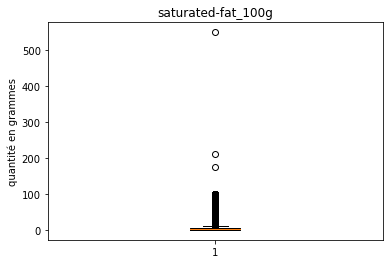

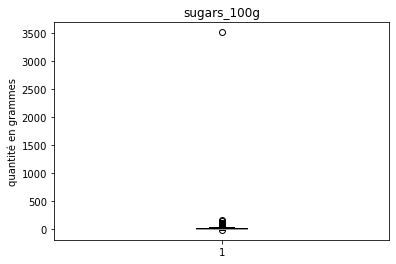

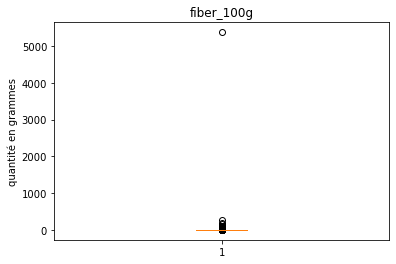

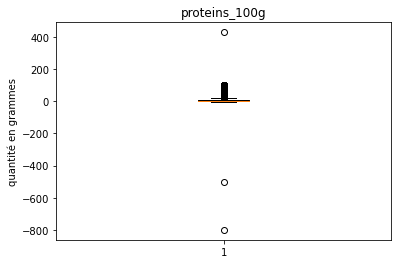

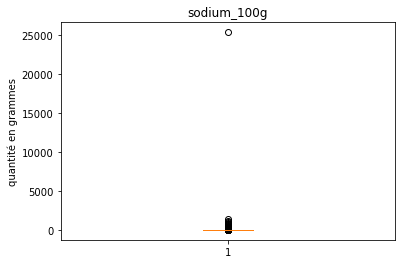

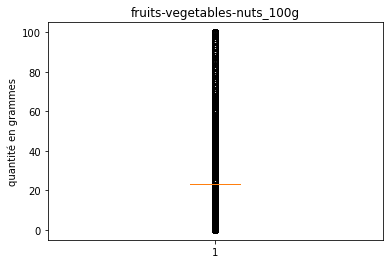

In [29]:
liste = ['saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']

#On affiche et modifie les éventuelles valeurs aberrantes pour chaque varibale choisie
for nutriment in liste:
    #on oublie les valeurs manquantes pour afficher le diagramme en boîte
    masque = data[nutriment].isnull()
    plt.boxplot(data[~masque][nutriment])
    plt.ylabel('quantité en grammes')
    plt.title(nutriment)
    plt.show()
    #on récupère la liste d'indices des outliers
    listeIndexOutliers = data[(data[nutriment]<0) | (data[nutriment]>100)].index
    if len(listeIndexOutliers) > 0:
        j = list(data.columns).index(nutriment)
        for i in listeIndexOutliers:
            data.iloc[i,j] = data[~masque][nutriment].mean()


## <a name="C6">2.4 Création d'une nouvelle variable</a>
on va se servir de la variable `pnns_groups_2` pour créer la variable `regime_alimentaire` qui va contenir la liste des régimes dans lesquels le produit peut être consommé.

In [30]:
def listeRegime(categ):
    """Fonction qui prend en entrée une catégorie de produit et renvoie la liste des régimes alimentaires pouvant
    consommer le produit"""
    
    #sous listes de catégories 
    liste1 = ['unknown', 'One-dish meals', 'Fats', 'Tripe dishes', 'Salty and fatty products']
    liste2 = ['Pizza pies and quiche', 'Meat', 'Sandwich', 'Fish and seafood', 'Processed meat']
    liste3 = ['Dressings and sauces', 'Milk and yogurt', 'Cheese', 'Eggs', 'Ice cream', 'Dairy desserts', 'pastries']
    liste4 = ['Biscuits and cakes', 'Vegetables', 'Bread', 'Legumes', 'Sweets', 'Non-sugared beverages', 'Sweetened beverages',
         'vegetables', 'Soups', 'Chocolate products', 'Alcoholic beverages', 'Fruits', 'Cereals', 'Appetizers', 'Nuts', 
          'Breakfast cereals', 'Artificially sweetened beverages', 'Fruit juices', 'Dried fruits', 'Potatoes', 'Fruit nectars',
         'fruits', 'cereals', 'legumes', 'nuts']
    
    if categ in liste1:
        return ['inconnu']
    elif categ in liste2:
        return ['sans regime']
    elif categ in liste3:
        return ['sans regime', 'vegetarien']
    else:
        return ['sans regime', 'vegetarien', 'vegan']


On peut à présent ajouter la nouvelle variable `regime_alimentaire` à notre dataframe.

In [31]:
data['regime_alimentaire'] = data['pnns_groups_2'].transform(listeRegime)

# <a name="C7">Partie 3: Exportation du jeu de données néttoyé</a>

In [32]:
data.to_csv('dataNettoye.csv',sep = '\t', encoding='utf_8', index=False)